# Computing the Elo from the Tournament Statistics with BayesElo

In [113]:
import subprocess

In [114]:
tournament_results = "../results/tournament_games_temp_1.pgn"

In [115]:
bayes_elo = "../BayesElo/bayeselo"

In [116]:
bayeselo_commands= f"""\
readpgn {tournament_results}
elo
mm
exactdist
ratings
"""

In [117]:
results = subprocess.run(
    [bayes_elo], 
    input=bayeselo_commands, 
    text=True,  
    capture_output=True
)

In [118]:
print(results.stdout)

version 0057, Copyright (C) 1997-2010 Remi Coulom.
compiled Aug  8 2025 13:51:01.
This program comes with ABSOLUTELY NO WARRANTY.
This is free software, and you are welcome to redistribute it
under the terms and conditions of the GNU General Public License.
See http://www.gnu.org/copyleft/gpl.html for details.
ResultSet>ResultSet>ResultSet-EloRating>Iteration 100: 0.0044937 
Iteration 200: 0.00178 
Iteration 300: 0.000952369 
Iteration 400: 0.000572722 
Iteration 500: 0.000365493 
Iteration 600: 0.000241371 
Iteration 700: 0.000162814 
Iteration 800: 0.000111338 
Iteration 900: 7.68315e-05 
Iteration 1000: 5.33465e-05 
Iteration 1100: 3.71964e-05 
Iteration 1200: 2.6011e-05 
Iteration 1300: 1.8226e-05 
Iteration 1400: 1.2789e-05 
00:00:00,00
ResultSet-EloRating>10 left    
0 left    
00:00:00,00              
ResultSet-EloRating>Rank Name                          Elo    +    - games score oppo. draws 
   1 leela_chess_zero_policy_net  1178   32   28 32000  100%   -74    0% 
   2 leela_

### If you used the Leela Chess Zero policy net anchor from the searchless chess paper

In [119]:
bayeselo_anchor_commands= f"""\
readpgn {tournament_results}
elo
mm
exactdist
offset 2292 leela_chess_zero_policy_net
ratings
"""

In [120]:
anchored_results = subprocess.run(
    [bayes_elo], 
    input=bayeselo_anchor_commands, 
    text=True,  
    capture_output=True
)

In [121]:
print(anchored_results.stdout)

version 0057, Copyright (C) 1997-2010 Remi Coulom.
compiled Aug  8 2025 13:51:01.
This program comes with ABSOLUTELY NO WARRANTY.
This is free software, and you are welcome to redistribute it
under the terms and conditions of the GNU General Public License.
See http://www.gnu.org/copyleft/gpl.html for details.
ResultSet>ResultSet>ResultSet-EloRating>Iteration 100: 0.0044937 
Iteration 200: 0.00178 
Iteration 300: 0.000952369 
Iteration 400: 0.000572722 
Iteration 500: 0.000365493 
Iteration 600: 0.000241371 
Iteration 700: 0.000162814 
Iteration 800: 0.000111338 
Iteration 900: 7.68315e-05 
Iteration 1000: 5.33465e-05 
Iteration 1100: 3.71964e-05 
Iteration 1200: 2.6011e-05 
Iteration 1300: 1.8226e-05 
Iteration 1400: 1.2789e-05 
00:00:00,00
ResultSet-EloRating>10 left    
0 left    
00:00:00,00              
ResultSet-EloRating>ResultSet-EloRating>Rank Name                          Elo    +    - games score oppo. draws 
   1 leela_chess_zero_policy_net  2292   32   28 32000  100%  104

## Plotting the elo ratings 

In [122]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import subprocess
import re
import leela_interp.tools.figure_helpers as fh

In [123]:
# Enable LaTeX rendering in matplotlib
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": "Times New Roman",
    "axes.labelsize": 22,
    "font.size": 11,
    "legend.fontsize": 20,
    "xtick.labelsize": 18,
    "ytick.labelsize": 18,
    "figure.dpi": 300,
    "savefig.bbox": "tight",
    "savefig.pad_inches": 0.05
})

In [124]:
PLOT_FACE_COLOR = fh.PLOT_FACE_COLOR
LINE_WIDTH = 2
COLORS = ['#0173B2', '#CC78BC', '#D55E00', '#009E73']

In [125]:
def parse_bayeselo_output(output, anchor_name, anchor_elo):
    """Parse BayesElo output and extract Elo ratings."""
    lines = output.split('\n')
    
    # Find the ratings table
    in_table = False
    ratings = {}
    
    for line in lines:
        if 'Rank Name' in line:
            in_table = True
            continue
        
        if in_table and line.strip():
            # Parse table line
            parts = line.split()
            if len(parts) >= 3:
                try:
                    rank = int(parts[0])
                    name = parts[1]
                    elo = int(parts[2])
                    ratings[name] = elo
                except (ValueError, IndexError):
                    continue
    
    return ratings

In [126]:
def get_tournament_elos(pgn_file, anchor_elo=2292):
    """Run BayesElo and extract ratings."""
    bayes_elo = "../BayesElo/bayeselo"
    anchor_name = "leela_chess_zero_policy_net"
    
    bayeselo_commands = f"""\
readpgn {pgn_file}
elo
mm
exactdist
offset {anchor_elo} {anchor_name}
ratings
"""
    
    results = subprocess.run(
        [bayes_elo], 
        input=bayeselo_commands, 
        text=True,  
        capture_output=True
    )
    
    return parse_bayeselo_output(results.stdout, anchor_name, anchor_elo)

In [127]:
import matplotlib.patheffects as pe

def plot_tournament_elos():
    """Plot Elo ratings across layers for different temperatures."""
    
    # Get ratings for both temperatures
    ratings_temp0 = get_tournament_elos("../results/tournament_games_temp_0.pgn")
    ratings_temp1 = get_tournament_elos("../results/tournament_games_temp_1.pgn")
    
    # Create layer mapping
    layer_names = ['leela_logit_lens_layer_0'] + \
                  [f'leela_logit_lens_layer_{i}' for i in range(1, 15)] + \
                  ['leela_logit_lens_full_model']
    
    # Extract Elo values
    elos_temp0 = [ratings_temp0.get(name, np.nan) for name in layer_names]
    elos_temp1 = [ratings_temp1.get(name, np.nan) for name in layer_names]
    
    # Create x-axis positions
    x_positions = list(range(len(layer_names)))
    
    # Create figure
    fig, ax = plt.subplots(figsize=(6, 4))
    
    # Plot both temperature lines
    ax.plot(x_positions, elos_temp0, 
            color=COLORS[0], linewidth=LINE_WIDTH, 
            label='Deterministic $(\\tau = 0)$')
    
    ax.plot(x_positions, elos_temp1, 
            color=COLORS[1], linewidth=LINE_WIDTH,
            label='Stochastic $(\\tau = 1)$')
    
    # Add annotation for "Plateauing strength"
    # Point to middle of plateau (around layer 7-8)
    arrow_x = 9  # Middle layers
    # Point between the two lines
    arrow_y_target = ((elos_temp0[arrow_x] + elos_temp1[arrow_x]) / 2) -50
    
    # Annotation position (above and to the left)
    annotation_x = 12
    annotation_y = arrow_y_target - 500  # Adjust based on your y-scale
    
    # Create annotation with arrow
    ann = ax.annotate(
        'Plateauing\nstrength',
        xy=(arrow_x, arrow_y_target),
        xytext=(annotation_x, annotation_y),
        fontsize=16,
        color='#DC143C',  # Or '#DC143C' for red
        ha='center',
        va='bottom',
        arrowprops=dict(
            arrowstyle='->',
            color='#DC143C',  # Or '#DC143C' for red
            lw=2,
            connectionstyle='arc3,rad=-0.3'
        ),
        zorder=20
    )
    
    # Add white outline to text
    ann.set_path_effects([
        pe.withStroke(linewidth=3, foreground="white", alpha=0.9)
    ])
    
    # Formatting
    ax.set_xlabel('Layer')
    ax.set_ylabel('Elo Rating')
    ax.set_xlim(0, len(x_positions) - 1)
    
    # Set y-axis limits
    y_min = min(min(elos_temp0), min(elos_temp1))
    y_max = max(max(elos_temp0), max(elos_temp1))
    y_range = y_max - y_min
    ax.set_ylim(y_min - 0.05 * y_range, y_max + 0.05 * y_range)
    
    # Create x-tick labels
    x_tick_labels = ['Input'] + [str(i) for i in range(14)] + ['Final']
    
    num_layers = len(x_positions)
    if num_layers <= 8:
        ax.set_xticks(x_positions)
        ax.set_xticklabels(x_tick_labels)
    else:
        step = max(1, num_layers // 5)
        selected_ticks = list(range(0, num_layers, step))
        if num_layers - 1 not in selected_ticks:
            selected_ticks.append(num_layers - 1)
        
        ax.set_xticks(selected_ticks)
        ax.set_xticklabels([x_tick_labels[i] for i in selected_ticks], rotation=0)
    
    # Styling
    ax.spines[:].set_visible(False)
    ax.set_facecolor(PLOT_FACE_COLOR)
    ax.grid(linestyle="--", alpha=0.8)
    ax.grid(which="minor", alpha=0.3, linestyle="--")
    
    # Phase shading
    ax.axvspan(0, 6, facecolor='black', alpha=0.05, zorder=0)
    ax.axvspan(12, 15, facecolor='black', alpha=0.05, zorder=0)
    
    # Legend
    ax.legend()
    
    plt.tight_layout()
    
    # Print summary
    print("=== TOURNAMENT ELO RATINGS ===")
    print("\nTemperature 0:")
    for name, elo in zip(x_tick_labels, elos_temp0):
        print(f"  {name:>6}: {elo:>4}")
    
    print("\nTemperature 1:")
    for name, elo in zip(x_tick_labels, elos_temp1):
        print(f"  {name:>6}: {elo:>4}")
    
    return fig, ax

=== TOURNAMENT ELO RATINGS ===

Temperature 0:
   Input:  443
       0:  650
       1:  699
       2:  790
       3:  871
       4:  962
       5: 1007
       6:  993
       7: 1014
       8: 1006
       9: 1042
      10: 1057
      11: 1083
      12: 1337
      13: 1681
   Final: 2263

Temperature 1:
   Input:  369
       0:  701
       1:  708
       2:  813
       3:  911
       4: 1080
       5: 1098
       6: 1064
       7: 1068
       8: 1069
       9: 1110
      10: 1113
      11: 1151
      12: 1355
      13: 1394
   Final: 1640


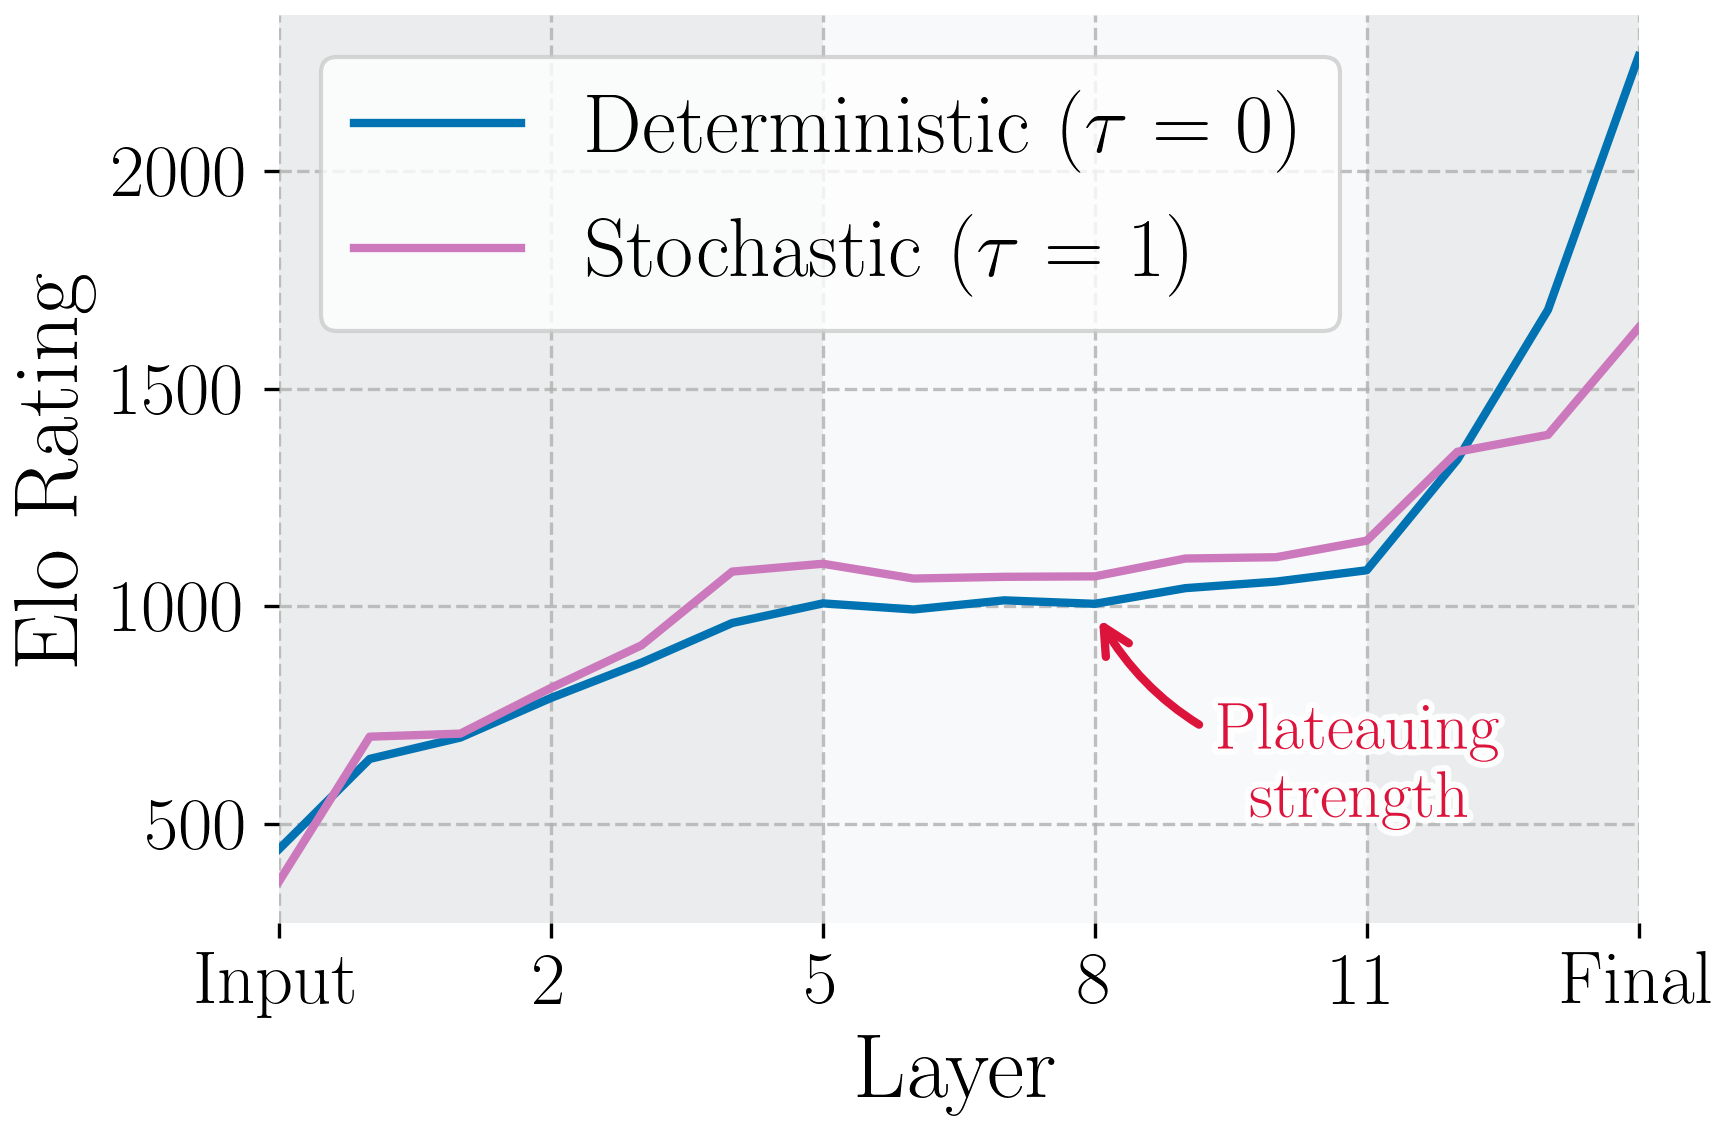

In [128]:
fig, ax = plot_tournament_elos()
plt.savefig('Figures/tournament_elos.pdf')
plt.savefig('Figures/tournament_elos.png', 
            dpi=1200, 
            bbox_inches='tight',
            pad_inches=0.0,
            facecolor='none')
plt.show()